# Ensemble learning: QRT Challenge

## Load libraries

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation
from prophet import Prophet
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from sklearn.impute import KNNImputer

## Load file

In [43]:
X_train = pd.read_csv("data/X_train_NHkHMNU.csv")
X_test = pd.read_csv("data/X_test_final.csv")
y_train = pd.read_csv("data/y_train_ZAN5mwg.csv")

In [44]:
X_train

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459,809,DE,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,...,0.509514,NaN,NaN,NaN,NaN,NaN,NaN,0.876984,0.819520,1.320373
1490,1674,887,FR,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,...,1.666252,NaN,NaN,NaN,NaN,NaN,NaN,0.932633,-0.085690,0.356356
1491,748,1083,DE,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,...,0.358120,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152
1492,1454,1133,FR,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,...,-0.184862,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812


## Data cleaning

In [23]:
#Missing values
missing_values_count_train = X_train.isnull().sum()/len(X_train)*100
missing_values_count_test = X_test.isnull().sum()/len(X_train)*100

print("Missing Values per Variable in %:")
print(missing_values_count_test)

Missing Values per Variable in %:
ID                  0.0
DAY_ID              0.0
DE_CONSUMPTION      0.0
FR_CONSUMPTION      0.0
DE_FR_EXCHANGE      0.0
DE_NET_EXPORT       0.0
FR_NET_EXPORT       0.0
DE_GAS              0.0
FR_GAS              0.0
DE_COAL             0.0
FR_COAL             0.0
DE_HYDRO            0.0
FR_HYDRO            0.0
DE_NUCLEAR          0.0
FR_NUCLEAR          0.0
DE_SOLAR            0.0
FR_SOLAR            0.0
DE_WINDPOW          0.0
FR_WINDPOW          0.0
DE_LIGNITE          0.0
DE_RESIDUAL_LOAD    0.0
DE_RAIN             0.0
FR_RAIN             0.0
DE_WIND             0.0
FR_WIND             0.0
DE_TEMP             0.0
FR_TEMP             0.0
GAS_RET             0.0
COAL_RET            0.0
CARBON_RET          0.0
FRANCE              0.0
DATE                0.0
dtype: float64


In [8]:
def preprocessing(df,value):
  ## FIND COLUMNS WITH MISSING VALUE
  missing_values_count = df.isnull().sum()/len(df)*100
  columns_with_missing_values = missing_values_count[missing_values_count > 0].index.tolist()
  columns_with_missing_values = list(set(columns_with_missing_values))

  ## INPUT MISSING VALUE WITH KNNIMPUTER
  knn_imputer = KNNImputer(n_neighbors=5)
  df[columns_with_missing_values] = knn_imputer.fit_transform(df[columns_with_missing_values])

  ## DUMMY ENCONDING
  df['FRANCE'] = df['COUNTRY'].apply(lambda x: 1 if x == 'FR' else 0)
  df['DEUTSCHLAND'] = df['COUNTRY'].apply(lambda x: 1 if x == 'DE' else 0)
  df = df.drop(columns = ['COUNTRY'])

  ## DROP HIGH CORRELATION COL
  high_corr_columns = []
  if value == 'train' and y_train is not None:
      merged_data = df.merge(y_train, how='inner', on='ID')
      corr_matrix = merged_data.corr()

      for i in range(len(corr_matrix.columns)):
          for j in range(i):
              if abs(corr_matrix.iloc[i, j]) > 0.9:
                  colname = corr_matrix.columns[i]  # Nom de la colonne ayant une forte corrélation
                  if corr_matrix.columns[j] not in high_corr_columns:
                      high_corr_columns.append(colname)

      df = df.drop(columns=high_corr_columns)

  if value == 'test':
      corr_matrix = df.corr()

      for i in range(len(corr_matrix.columns)):
          for j in range(i):
              if abs(corr_matrix.iloc[i, j]) > 0.9:
                  colname = corr_matrix.columns[i]  # Nom de la colonne ayant une forte corrélation
                  if corr_matrix.columns[j] not in high_corr_columns:
                      high_corr_columns.append(colname)

      df = df.drop(columns=high_corr_columns)


  ## ADD DATE COL
  start_date = pd.to_datetime('2020-01-01')
  df['DATE'] = df['DAY_ID'].apply(lambda x: start_date + pd.Timedelta(days=x-1))




  return df


X_train  = preprocessing(X_train, 'train')
X_test = preprocessing(X_test, 'test')

# Data Visualisation

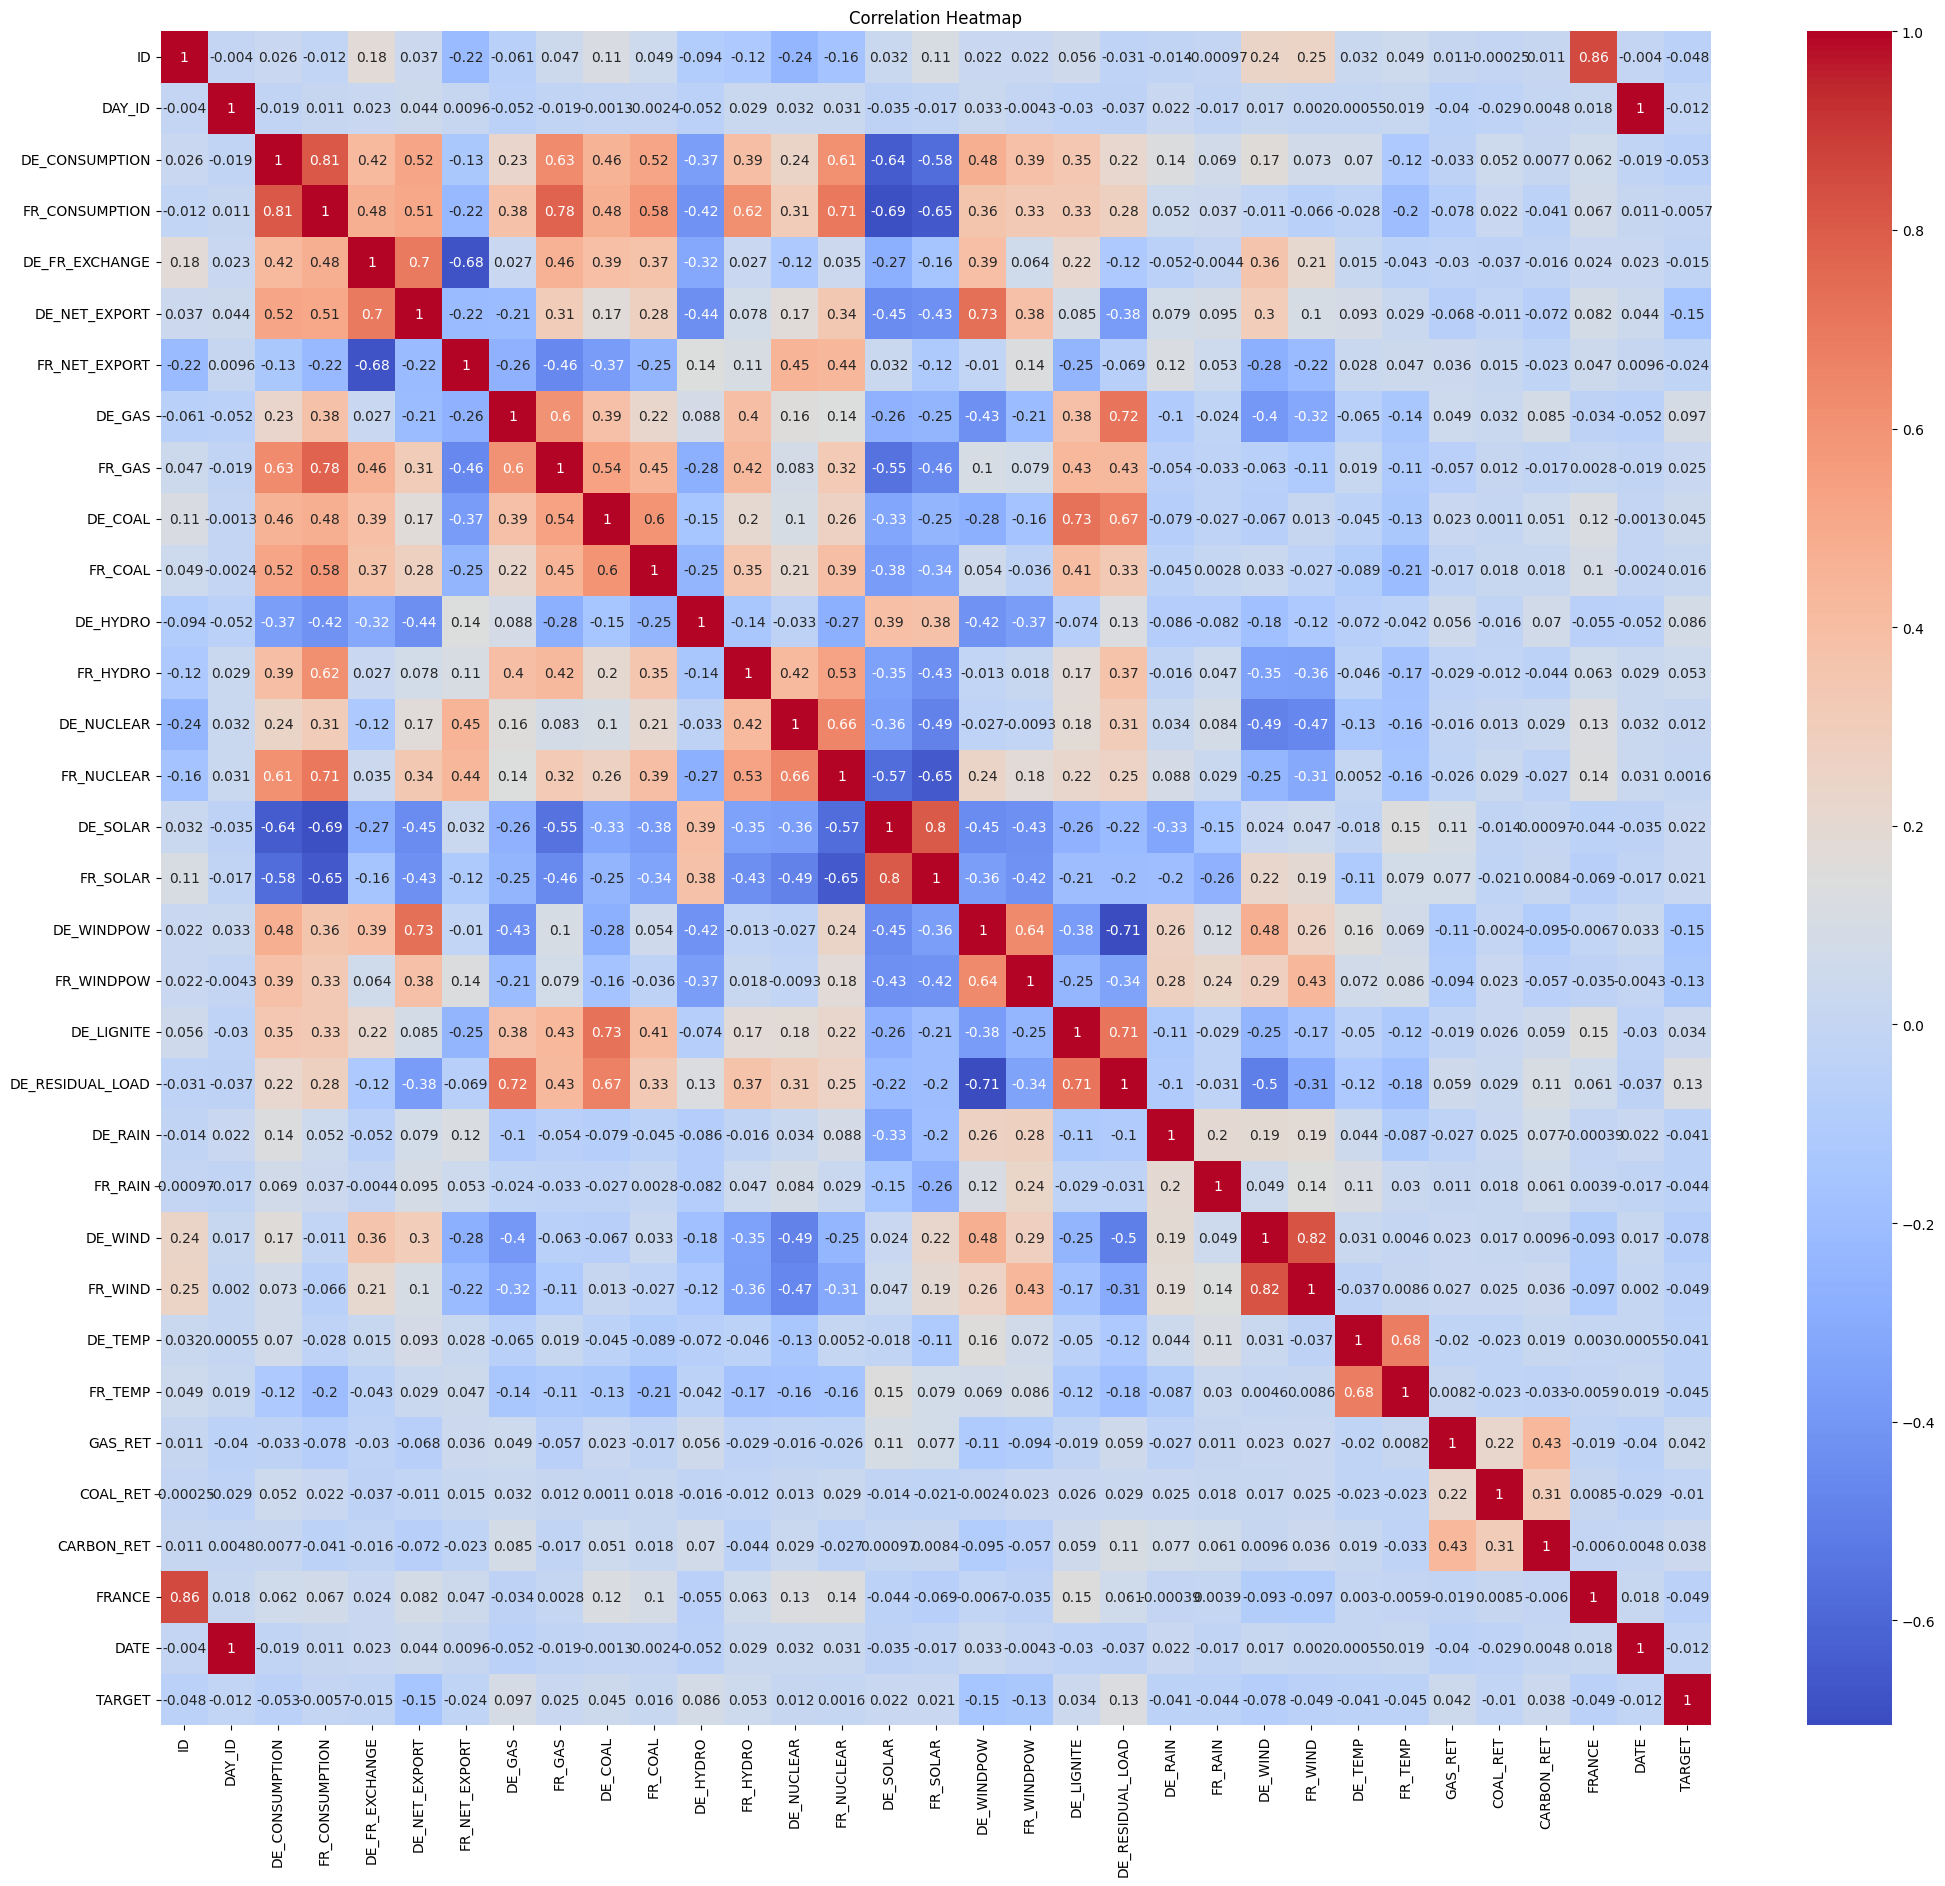

In [9]:
merged_data = X_train.merge(y_train, how = 'inner', on = 'ID')
#Corrélation
corr_matrix = merged_data.corr()

#Heatmap
plt.figure(figsize=(25, 22))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [10]:
summary_stats = merged_data.describe()

# Display the mean, standard deviation, and other metrics for the 'TARGET' column
target_stats = merged_data['TARGET'].describe()

print("Summary Statistics for All Columns:")
print(summary_stats)

print("\nSummary Statistics for 'TARGET' Column:")
print(target_stats)

Summary Statistics for All Columns:
                ID       DAY_ID  DE_CONSUMPTION  FR_CONSUMPTION  \
count  1494.000000  1494.000000     1494.000000     1494.000000   
mean   1072.759036   591.861446        0.427442       -0.020032   
min       0.000000     0.000000       -2.265563       -1.462350   
25%     540.250000   292.250000       -0.037421       -0.716771   
50%    1077.500000   591.000000        0.357061       -0.394166   
75%    1597.500000   885.750000        0.922057        0.650533   
max    2146.000000  1215.000000        2.033851        3.300640   
std     618.013179   345.065043        0.673412        0.918995   

       DE_FR_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT       DE_GAS       FR_GAS  \
count     1494.000000    1494.000000    1494.000000  1494.000000  1494.000000   
mean        -0.145479      -0.240018      -0.067991     0.780699     0.395019   
min         -2.856874      -2.464849      -2.825331    -1.117260    -1.317350   
25%         -0.872289      -0.930069

# Modelling

# Prophet Modeling - BaseLine Model

In [14]:
# Merge X_train and Y_train
train_data = X_train.merge(y_train, on='ID')

# Selecting the 'DAY_ID' and 'TARGET' for Prophet
prophet_train_data =train_data
prophet_train_data.rename(columns={'DATE': 'ds', 'TARGET': 'y'}, inplace=True)


In [15]:
# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Get the absolute correlation values with the target variable
corr_with_target = abs(corr_matrix['TARGET'])

# Select the top 5 features with the highest correlation values
top_5_regressors = corr_with_target.nlargest(6)[1:].index.tolist()

# Print the top 5 regressors
print("Top 5 regressors according to correlation with the target:")
print(top_5_regressors)


KeyError: 'TARGET'

In [31]:
from prophet import Prophet

# Create a new Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')

# Add holidays for France and Germany
model.add_country_holidays(country_name='FR')
model.add_country_holidays(country_name='DE')

# Add regressors from the list 'top_5_regressors'
for regressor in top_5_regressors:
    model.add_regressor(regressor)

# Fit the model to the training data
model.fit(prophet_train_data)


Changing country holidays from 'FR' to 'DE'.


23:33:01 - cmdstanpy - INFO - Chain [1] start processing
23:33:01 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
X_test['DE_WINDPOW']

0     -1.145765
1     -0.211726
2      2.373643
3     -1.146251
4     -0.274033
         ...   
649    1.615553
650    0.658971
651   -0.863431
652   -0.752465
653   -0.314779
Name: DE_WINDPOW, Length: 654, dtype: float64

In [33]:
future = model.make_future_dataframe(periods=len(X_test), freq='D')

# Add additional regressors to the future dataframe
for regressor in top_5_regressors:
    future[regressor] = X_test[regressor]

future['DE_WINDPOW'].fillna(future['DE_WINDPOW'].mean(), inplace=True)
future['DE_NET_EXPORT'].fillna(future['DE_NET_EXPORT'].mean(), inplace=True)
future['DE_RESIDUAL_LOAD'].fillna(future['DE_RESIDUAL_LOAD'].mean(), inplace=True)
future['FR_WINDPOW'].fillna(future['FR_WINDPOW'].mean(), inplace=True)
future['DE_GAS'].fillna(future['DE_RESIDUAL_LOAD'].mean(), inplace=True)
forecast = model.predict(future)


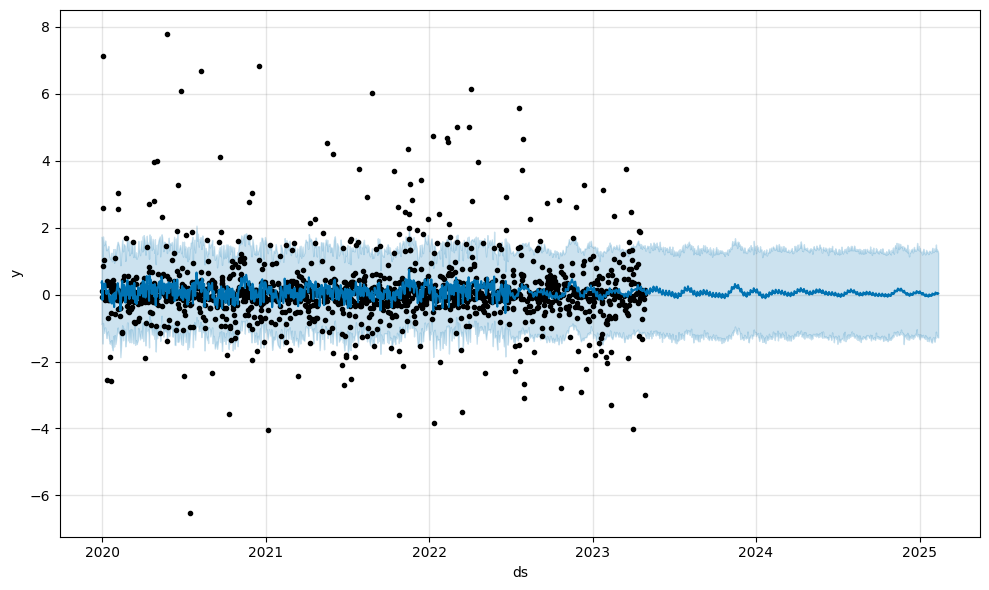

In [34]:
# Tracer les prévisions
fig1 = model.plot(forecast)


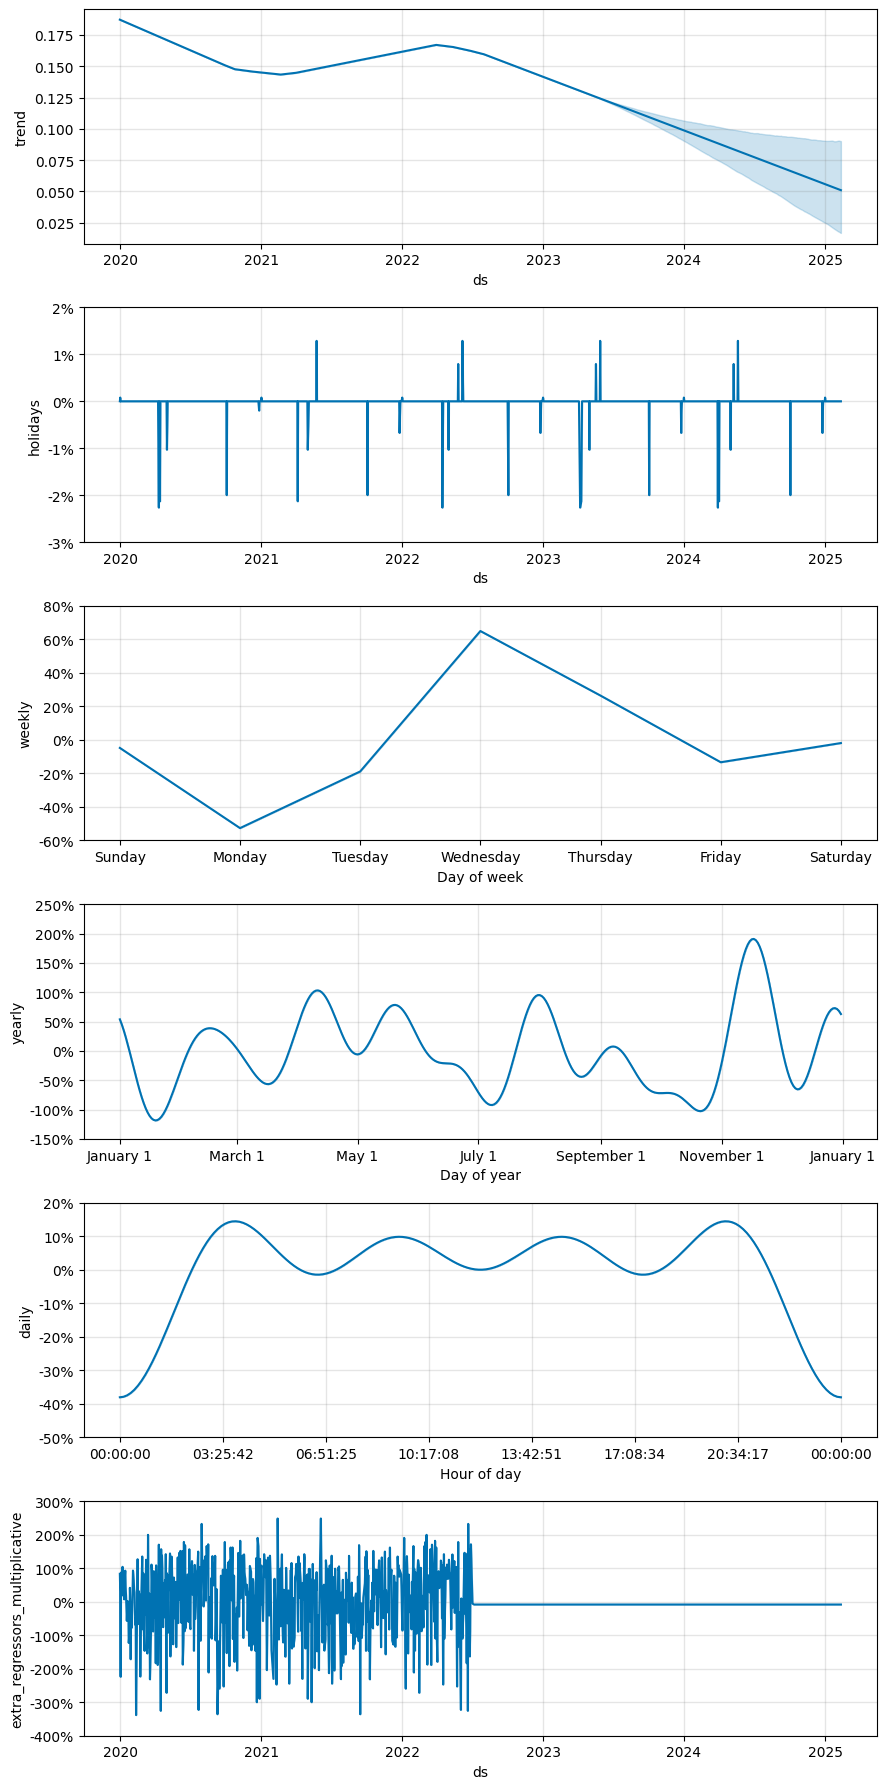

In [35]:
# Tracer les composants des prévisions (tendance, saisonnalité annuelle, hebdomadaire, etc.)
fig2 = model.plot_components(forecast)


In [36]:
# Calculate Spearman's correlation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
spearman_corr = spearmanr(df_cv['y'], df_cv['yhat'])

print(f"Spearman's correlation coefficient: {spearman_corr.correlation}")

  0%|          | 0/1 [00:00<?, ?it/s]

23:33:23 - cmdstanpy - INFO - Chain [1] start processing
23:33:23 - cmdstanpy - INFO - Chain [1] done processing


Spearman's correlation coefficient: 0.09695751394967796


## Split train test to test the model

In [37]:
def spearman_scorer(y_true, y_pred):
    # Calculate Spearman's correlation
    correlation, _ = spearmanr(y_true, y_pred)
    return correlation

# Create a scorer that can be used in GridSearchCV
spearman_scoring = make_scorer(spearman_scorer)

# Preprocess for Gradiant Boosting

In [38]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.stattools import acf

def optimize_lags_and_train_model(X_train, y_train, max_lag=100, n_estimators=1000, learning_rate=0.1, value= 'train'):
    """
    Optimise les décalages pour les caractéristiques de X_train basé sur l'autocorrélation
    et entraîne un modèle de Gradient Boosting avec ces caractéristiques optimisées.

    :param X_train: DataFrame des caractéristiques d'entraînement.
    :param y_train: Série ou array de la cible d'entraînement.
    :param max_lag: Le nombre maximal de décalages à examiner pour chaque caractéristique.
    :param n_estimators: Le nombre d'arbres pour le Gradient Boosting.
    :param learning_rate: Le taux d'apprentissage pour le Gradient Boosting.
    :return: Le modèle entraîné et le DataFrame d'entraînement avec les caractéristiques optimisées.
    """
    def preprocess_dates(df):
      date_columns = df.select_dtypes(include=['datetime64[ns]']).columns
      for col in date_columns:
          # Exemple d'extraction de caractéristiques temporelles
          df[f'{col}_year'] = df[col].dt.year
          df[f'{col}_month'] = df[col].dt.month
          df[f'{col}_day'] = df[col].dt.day
          # Supprimer la colonne de date originale
          df = df.drop(columns=[col])
      return df

    if value == 'train':
      # Appliquer la fonction de prétraitement des dates avant le reste du prétraitement
      X_train = preprocess_dates(X_train)

      # Copie du DataFrame pour ajouter les décalages
      X_train_optimized = X_train.copy()

      for column in X_train.columns:
          # Calcul de l'autocorrélation pour chaque décalage
          autocorr_lags = [acf(X_train[column].shift(lag+1).fillna(method='bfill'), nlags=1)[1] for lag in range(max_lag)]

          # Identification du décalage avec la plus forte autocorrélation
          best_lag = np.argmax(autocorr_lags) + 1  # +1 pour ajuster l'index 0

          # Si le meilleur décalage est significatif, créer une nouvelle caractéristique décalée
          if autocorr_lags[best_lag-1] > 0.4:  # Seuil arbitraire de significativité
              X_train_optimized[f'{column}_lag_{best_lag}'] = X_train[column].shift(best_lag).fillna(method='bfill')

      # Entraînement du modèle de Gradient Boosting avec les caractéristiques optimisées
      model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
      model.fit(X_train_optimized, y_train.drop(columns = ['ID']).values.ravel())

      return model, X_train_optimized

    if value == 'test':
      # Appliquer la fonction de prétraitement des dates avant le reste du prétraitement
      X_test = preprocess_dates(X_train)

      # Copie du DataFrame pour ajouter les décalages
      X_test_optimized = X_test.copy()

      for column in X_test.columns:
          # Calcul de l'autocorrélation pour chaque décalage
          autocorr_lags = [acf(X_test[column].shift(lag+1).fillna(method='bfill'), nlags=1)[1] for lag in range(max_lag)]

          # Identification du décalage avec la plus forte autocorrélation
          best_lag = np.argmax(autocorr_lags) + 1  # +1 pour ajuster l'index 0

          # Si le meilleur décalage est significatif, créer une nouvelle caractéristique décalée
          if autocorr_lags[best_lag-1] > 0.4:  # Seuil arbitraire de significativité
              X_test_optimized[f'{column}_lag_{best_lag}'] = X_test[column].shift(best_lag).fillna(method='bfill')
      return X_test_optimized

# Pour l'entraînement
model, X_train_optimized = optimize_lags_and_train_model(X_train, y_train, value='train')

# Pour le test
X_test_optimized = optimize_lags_and_train_model(X_test, y_train=None, value='test')



In [39]:

X_train_optimized.shape

(1494, 34)

In [40]:
# Determine the split point for creating a validation set from the training data
split_ratio = 0.8  # for example, 80% of the data for training, 20% for validation
split_index = int(len(X_train_optimized) * split_ratio)

# Split the training data and outputs into training and validation sets
X_train_split = X_train_optimized.iloc[:split_index]
Y_train_split = y_train.iloc[:split_index]
X_val_split = X_train_optimized.iloc[split_index:]
Y_val_split = y_train.iloc[split_index:]

## Gradient boosting

In [41]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

#Create a gradient boosting model
grid_search = GridSearchCV(model, param_grid, scoring=spearman_scoring, cv=5)

grid_search.fit(X_train_split, Y_train_split.drop(columns = ['ID']).values.ravel())

#Get the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

predictions = best_estimator.predict(X_val_split)

#Make predictions on the test set
cv_scores = cross_val_score(best_estimator, X_val_split, Y_val_split.drop(columns = ['ID']).values.ravel(), scoring='neg_mean_squared_error', cv=5)
cv_mse = -cv_scores.mean()

mse = mean_squared_error(Y_val_split.drop(columns = ['ID']).values.ravel(), predictions)


spearman_corr = spearmanr(Y_val_split.drop(columns = ['ID']).values.ravel(), predictions).correlation

print(f'Improved Mean Squared Error on Test Set: {mse}')
print(f'Cross-Validation Mean Squared Error: {cv_mse}')
print(f'Spearman Correlation on Test Set: {spearman_corr}')
print(f'Grid Search Best Params : {grid_search.best_params_}')

Improved Mean Squared Error on Test Set: 0.9204420803230002
Cross-Validation Mean Squared Error: 0.9104643271360866
Spearman Correlation on Test Set: 0.14510208793778834
Grid Search Best Params : {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}


## Adaboost

In [ ]:
base_model = DecisionTreeRegressor(max_depth=3)
adaboost_model = AdaBoostRegressor(base_model)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}


#Create a gradient boosting model
grid_search = GridSearchCV(adaboost_model, param_grid, scoring=spearman_scoring, cv=5)

grid_search.fit(X_train_split, Y_train_split.drop(columns = ['ID']).values.ravel())

#Get the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

predictions = best_estimator.predict(X_val_split)

#Make predictions on the test set
cv_scores = cross_val_score(best_estimator, X_val_split, Y_val_split.drop(columns = ['ID']).values.ravel(), scoring='neg_mean_squared_error', cv=5)
cv_mse = -cv_scores.mean()

mse = mean_squared_error(Y_val_split.drop(columns = ['ID']).values.ravel(), predictions)


spearman_corr = spearmanr(Y_val_split.drop(columns = ['ID']).values.ravel(), predictions).correlation

print(f'Improved Mean Squared Error on Test Set: {mse}')
print(f'Cross-Validation Mean Squared Error: {cv_mse}')
print(f'Spearman Correlation on Test Set: {spearman_corr}')
print(f'Grid Search Best Params : {grid_search.best_params_}')

In [ ]:
base_model = DecisionTreeRegressor(max_depth=3)

adaboost_model = AdaBoostRegressor(base_model)

#Hyperparameter tunning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

#GridSearchCV
grid_search_adaboost = GridSearchCV(adaboost_model, param_grid, scoring=spearman_scoring, cv=5)

grid_search_adaboost.fit(X_train_split, Y_train_split)

#Best params
best_params_adaboost = grid_search_adaboost.best_params_

#New Adaboost model with the best params
best_adaboost_model = AdaBoostRegressor(base_model, **best_params_adaboost)

#Train the model with the best parameters
best_adaboost_model.fit(X_train_model, y_train_model)

#Predictions on the test set
best_adaboost_predictions = best_adaboost_model.predict(X_test_model)

best_adaboost_mse = mean_squared_error(y_test_model, best_adaboost_predictions)
print(f'Improved Mean Squared Error on Test Set for AdaBoost: {best_adaboost_mse}')

cv_scores_best_adaboost = cross_val_score(best_adaboost_model, X_train_model, y_train_model, scoring='neg_mean_squared_error', cv=5)
cv_mse_best_adaboost = -cv_scores_best_adaboost.mean()
print(f'Cross-Validation Mean Squared Error for AdaBoost: {cv_mse_best_adaboost}')

spearman_corr = spearmanr(y_test_model, best_adaboost_predictions).correlation
print(f'Spearman Correlation on Test Set: {spearman_corr}')

In [ ]:
best_params_adaboost

try to add new features/delete features, polynomial features,

## Submission

In [ ]:
Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = best_adaboost_model.predict(X_test)
Y_test_submission.to_csv('benchmark_qrt.csv', index=False)